## Note, only using comments_df for now until we figure out if it is worth it to use the posts_df as well somehow

# 1: Import Packages, define functions


In [264]:
# Import some libraries that will be used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import mysql.connector
# some_file.py
import sys
sys.path.insert(1, '/Users/brianmccabe/DataScience/Flatiron/mod4/Reddit_NLP/Scripts')
#import config
pd.set_option('display.max_columns', 300)

%matplotlib inline

In [265]:
import nltk
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import train_test_split
from matplotlib import cm
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
import string

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alecmccabe/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/alecmccabe/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/alecmccabe/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [266]:
from nltk.stem import WordNetLemmatizer 
  
lemmatizer = WordNetLemmatizer()

In [267]:
# we can define a function that removes stopwords 
def process_comment(comment):
    comment = comment.lower()
    tokens = nltk.word_tokenize(comment)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stopwords]
    return stopwords_removed

In [268]:
def capital_percentage(comment):
    tokens = nltk.word_tokenize(comment)
    cap_count = 0
    for item in tokens:
        if item.isupper():
            cap_count += 1
    return cap_count/len(tokens)



In [269]:
#set stopwords and punctuations
stopwords = stopwords.words('english')
stopwords += list(string.punctuation)
stopwords += ["n't", "' '", "'re'","”","``","“","''","’","'s","'re","http","https"]

# 2: Load in the data

In [270]:
posts_df = pd.read_csv('/Users/alecmccabe/Desktop/Flatiron/Projects/Mod4/Reddit_NLP/csv_data/posts_df.csv', index_col=0)
comments_df = pd.read_csv('/Users/alecmccabe/Desktop/Flatiron/Projects/Mod4/Reddit_NLP/csv_data/comments_df.csv', index_col=0)

In [271]:
posts_df.columns = ['id_num', 'post_title', 'post_author', 'post_upvote_ratio', 'post_id', 'post_class']

In [272]:
comments_df.columns = ['id_num', 'body', 'comment_id', 'parent_id', 'post_id', 'author', 'score', 'comment_class']

In [273]:
import re

pattern = '\w+_(\w+)'
p = re.compile(pattern)

In [274]:
comments_df.post_id = comments_df.post_id.apply(lambda x: p.findall(x)[0])

In [275]:
# GET RID OF NEGATIVE SCORES (a negative score in a conservative subreddit could be a brigader for example)
comments_df = comments_df[comments_df.score > 5]

In [276]:
df = comments_df[['body', 'comment_class']]

In [277]:
df.comment_class.value_counts()

right    17251
left     15759
Name: comment_class, dtype: int64

# 3: Initial EDA

In [278]:
df['capital_percentage'] = df.body.apply(capital_percentage)

<ipython-input-278-8329d89493b0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['capital_percentage'] = df.body.apply(capital_percentage)


In [279]:
all_caps = df[df.capital_percentage == 1].sort_values(by='capital_percentage', 
                                                      ascending=False).comment_class.value_counts()

In [280]:
comments_w_most_caps = df.sort_values(by='capital_percentage', 
                                      ascending=False).iloc[0:500].comment_class.value_counts()

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

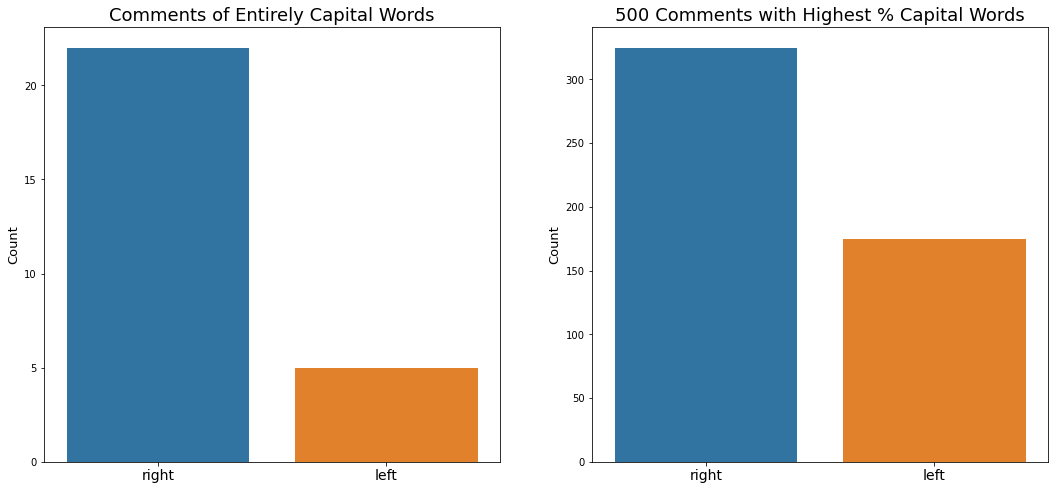

In [281]:
fig = plt.figure(figsize=(18,8))

ax1 = plt.subplot(1, 2, 1)
sns.barplot(all_caps.index, all_caps, ax=ax1)
plt.title("Comments of Entirely Capital Words", fontsize = 18)
plt.ylabel("Count", fontsize=13)
plt.xticks(fontsize=14)

ax2 = plt.subplot(1, 2, 2)
sns.barplot(comments_w_most_caps.index, comments_w_most_caps, ax=ax2)
plt.title("500 Comments with Highest % Capital Words", fontsize = 18)
plt.ylabel("Count", fontsize=13)
plt.xticks(fontsize=14)


In [282]:
leaning_map = {'right': 1, 'left': 0}
df.comment_class = df.comment_class.map(leaning_map)

In [283]:
df['text_len'] = df['body'].map(lambda x: len(x))

<ipython-input-283-67af6b43cc2d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_len'] = df['body'].map(lambda x: len(x))


In [284]:
df = df[df.text_len >= 100]
df.drop('text_len', axis=1, inplace=True)

In [285]:
df.comment_class.value_counts()

1    9106
0    9027
Name: comment_class, dtype: int64

In [286]:
from sklearn.utils import resample
right = df[df.comment_class == 1]
left = df[df.comment_class == 0]

left_upsampled = resample(left,
                          replace=True, # sample with replacement
                          n_samples=len(right), # match number in majority class
                          random_state=42) 
df = pd.concat([right, left_upsampled])
df.comment_class.value_counts()

1    9106
0    9106
Name: comment_class, dtype: int64

In [287]:
df.reset_index(drop=True, inplace=True)

# Word Counts and Word Clouds

In [288]:
df_freq_right = df[df['comment_class']==1]
df_freq_left = df[df['comment_class']==0]

data_right = df_freq_right['body']
data_left = df_freq_left['body']

processed_right = list(map(process_comment, data_right))
processed_left = list(map(process_comment, data_left))

In [289]:
# Preprocessing:
# We will use these again later on
# FORMAT:  flat_list = [item for sublist in l for item in sublist]

flat_right = [item for sublist in processed_right for item in sublist]
flat_left = [item for sublist in processed_left for item in sublist]

In [290]:
right_freq = FreqDist(flat_right)
left_freq = FreqDist(flat_left)

In [291]:
right_freq.most_common(20)

[('gun', 2750),
 ('people', 2607),
 ('like', 1840),
 ('would', 1600),
 ('get', 1366),
 ('one', 1342),
 ('guns', 1332),
 ('trump', 1178),
 ('biden', 1155),
 ('right', 1120),
 ('even', 985),
 ('think', 969),
 ('want', 942),
 ('...', 933),
 ('know', 859),
 ('time', 815),
 ('going', 804),
 ('rights', 791),
 ('us', 738),
 ('need', 738)]

In [292]:
left_freq.most_common(20)

[('trump', 4364),
 ('people', 2185),
 ('like', 1629),
 ('would', 1567),
 ('biden', 1509),
 ('vote', 1419),
 ('one', 1142),
 ('get', 1098),
 ('even', 939),
 ('going', 897),
 ('...', 890),
 ('election', 838),
 ('president', 835),
 ('time', 774),
 ('know', 767),
 ('think', 763),
 ('right', 763),
 ('said', 721),
 ('could', 706),
 ('years', 685)]

In [293]:
# create counts of satire and not satire with values and words
right_bar_counts = [x[1] for x in right_freq.most_common(25)]
right_bar_words = [x[0] for x in right_freq.most_common(25)]

left_bar_counts = [x[1] for x in left_freq.most_common(25)]
left_bar_words = [x[0] for x in left_freq.most_common(25)]

In [294]:
# set the color of our bar graphs
color = cm.viridis_r(np.linspace(.4,.8, 30))

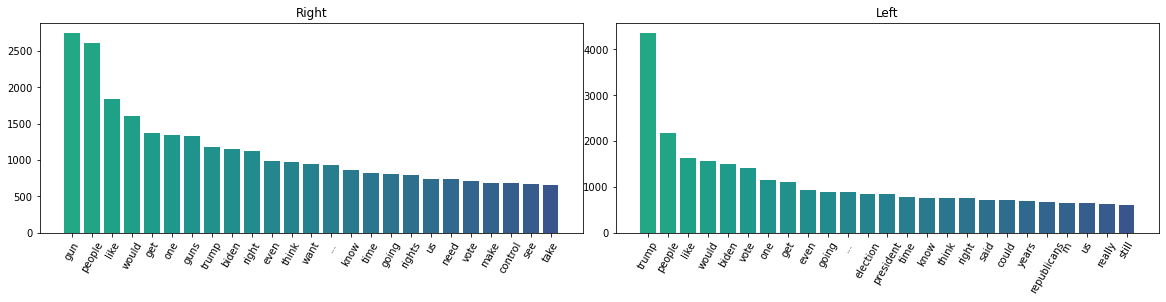

In [295]:
new_figure = plt.figure(figsize=(16,4))

ax = new_figure.add_subplot(121)
ax2 = new_figure.add_subplot(122)

# Generate a line plot on first axes
ax.bar(right_bar_words, right_bar_counts, color=color)
# ax.plot(colormap='PRGn')

# Draw a scatter plot on 2nd axes
ax2.bar(left_bar_words, left_bar_counts, color=color )

ax.title.set_text('Right')
ax2.title.set_text('Left')

for ax in new_figure.axes:
    plt.sca(ax)
    plt.xticks(rotation=60)

plt.tight_layout(pad=0)

# plt.savefig('word count bar graphs.png')

plt.show()

In [296]:
# Getting our data into a dictionary
# FORMAT:  dictionary = dict(zip(keys, values))
#!pip install wordcloud
from wordcloud import WordCloud
right_dictionary = dict(zip(right_bar_words, right_bar_counts))
left_dictionary = dict(zip(left_bar_words, left_bar_counts))

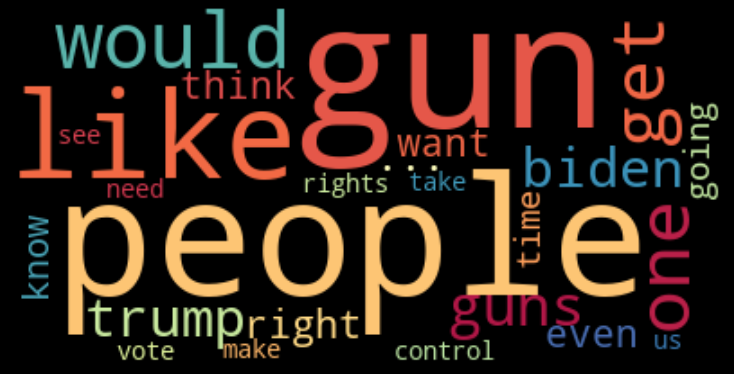

In [297]:
# Create the word cloud:

wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(right_dictionary)

# Display the generated image w/ matplotlib:

plt.figure(figsize=(10,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)

# Uncomment the next line if you want to save your image:
# plt.savefig('satire_wordcloud.png')

plt.show()

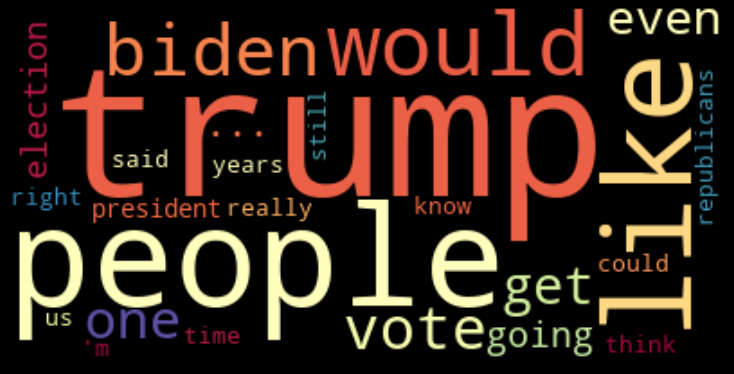

In [298]:
wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(left_dictionary)

plt.figure(figsize=(10,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
# plt.savefig('not_satire_wordcloud.png')

plt.show()

# Classification

In [299]:
X = df['body']
y = df['comment_class']

In [300]:
X

0        I hope y'all are cooler than the bitches on r/...
1        The people deserve to know exactly what Joe Bi...
2        And to think, it was a big enough story withou...
3        This was obvious to anyone with commonsense. I...
4        That’s how you know it Russian disinformation!...
                               ...                        
18207    Georgia turning blue feels like it would almos...
18208    It’s funny, despite seeing the 538 model slip ...
18209    We're at +20% of the total vote of 2016 and mo...
18210    There is no one in this family who is remotely...
18211    This might be the year we actually all start v...
Name: body, Length: 18212, dtype: object

In [301]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/alecmccabe/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [302]:
from sklearn.base import BaseEstimator, TransformerMixin

In [303]:
class Pronouns(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def count_pronouns(self, comment):
        comment = comment.lower()
        tokens = nltk.word_tokenize(comment)

        pos_tags = [i[1] for i in nltk.pos_tag(tokens)]
        count = 0
        pronouns = ['PRP','PRP$','WP','WP$']
        for pos in pos_tags:
            if pos in pronouns:
                count += 1

        return count
    
    def transform(self, X):
        return pd.Series(X).apply(self.count_pronouns)

In [304]:
pronouns = Pronouns()

In [305]:
pronouns.fit(X)

Pronouns()

In [326]:
pronouns_test = pronouns.transform(X)

In [308]:
#apply above function to data

processed_comments = list(map(process_comment, X))

**Back to Lemma**

In [309]:
#create list with lemmatized output
lemmatized_output = []

for comment in processed_comments:
    lemmed = ' '.join([lemmatizer.lemmatize(w) for w in comment])
    lemmatized_output.append(lemmed)

In [310]:
X_lem = lemmatized_output

y_lem = y

In [311]:
X_train_lem, X_test_lem, y_train_lem, y_test_lem = train_test_split(X_lem, y_lem, test_size=0.35, random_state=1)

In [96]:
import en_core_web_sm
nlp = en_core_web_sm.load()

In [263]:
import spacy 
from sklearn.base import BaseEstimator, TransformerMixin
class SpacyVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, nlp):
        self.nlp = nlp
        self.dim = 300

    def fit(self, X, y):
        return self

    def transform(self, X):
        # Doc.vector defaults to an average of the token vectors.
        # https://spacy.io/api/doc#vector
        
        return [self.nlp(text).vector for text in X]

In [98]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import classification_report

In [99]:
embeddings_pipeline = Pipeline(
    steps=[
        ("mean_embeddings", SpacyVectorTransformer(nlp)),
        ("reduce_dim", TruncatedSVD(50)),
        ("classifier", RandomForestClassifier()),
    ]
)
embeddings_pipeline.fit(X_train_lem, y_train_lem)
y_pred = embeddings_pipeline.predict(X_test_lem)
cr = classification_report(y_test_lem, y_pred,output_dict=True)

In [100]:
report = pd.DataFrame(cr).transpose()

In [101]:
report

,precision,recall,f1-score,support
0,0.824047,0.790560,0.806956,3199.000000
1,0.797338,0.829975,0.813329,3176.000000
accuracy,0.810196,0.810196,0.810196,0.810196
macro avg,0.810693,0.810267,0.810143,6375.000000
weighted avg,0.810741,0.810196,0.810131,6375.000000


In [102]:
tfidf_pipeline = Pipeline(
    steps=[
        ("tfidf", TfidfVectorizer()),
        ("classifier", RandomForestClassifier()),
    ]
)
tfidf_pipeline.fit(X_train_lem, y_train_lem)
y_pred = tfidf_pipeline.predict(X_test_lem)
cr = classification_report(y_test_lem, y_pred, output_dict=True)

In [103]:
report = pd.DataFrame(cr).transpose()

In [104]:
report

,precision,recall,f1-score,support
0,0.876088,0.912785,0.894060,3199.000000
1,0.908284,0.869962,0.888710,3176.000000
accuracy,0.891451,0.891451,0.891451,0.891451
macro avg,0.892186,0.891374,0.891385,6375.000000
weighted avg,0.892128,0.891451,0.891395,6375.000000


In [112]:
# individual pipelines minus the estimator step: 
tfidf_pipeline = Pipeline(
    steps=[
        ("tfidf", TfidfVectorizer()),
    ]
)

embeddings_pipeline = Pipeline(
    steps=[
        ("mean_embeddings", SpacyVectorTransformer(nlp)),
        ("reduce_dim", TruncatedSVD(50)),
    ]
)

In [113]:
combined_features = FeatureUnion(
    transformer_list=[
        ("tfidf", tfidf_pipeline),
        ("embeddings", embeddings_pipeline),
        #(try adding a pipeline that is just the dense columns)
    ]
)
final_pipeline = Pipeline(
    steps=[
        ("combined_features", combined_features),
        ("classifier", RandomForestClassifier()),
    ]
)

In [114]:
final_pipeline.fit(X_train_lem, y_train_lem)
y_pred = final_pipeline.predict(X_test_lem)
cr = classification_report(y_test_lem, y_pred, output_dict=True)

In [115]:
report = pd.DataFrame(cr).transpose()

In [116]:
report

,precision,recall,f1-score,support
0,0.853501,0.868709,0.861038,3199.000000
1,0.865341,0.849811,0.857506,3176.000000
accuracy,0.859294,0.859294,0.859294,0.859294
macro avg,0.859421,0.859260,0.859272,6375.000000
weighted avg,0.859400,0.859294,0.859278,6375.000000


In [313]:
tfidf = TfidfVectorizer(ngram_range=(1,2))

tfidf_data_train_lem = tfidf.fit_transform(X_train_lem)
tfidf_data_test_lem = tfidf.transform(X_test_lem)

tfidf_data_train_lem

<11837x197868 sparse matrix of type '<class 'numpy.float64'>'
	with 614156 stored elements in Compressed Sparse Row format>

In [325]:
test_df = pd.DataFrame(tfidf_data_train_lem.todense())

In [328]:
test_df['pronouns'] = pronouns_test

In [330]:
import scipy

In [331]:
scipy.sparse.csr_matrix(test_df)

<11837x197869 sparse matrix of type '<class 'numpy.float64'>'
	with 624916 stored elements in Compressed Sparse Row format>

## Random Forest

In [112]:
rfc_lemma = RandomForestClassifier(n_estimators=100,random_state=0,n_jobs=-1,verbose=1)
rfc_lemma.fit(tfidf_data_train_lem, y_train_lem)
rf_test_preds = rfc_lemma.predict(tfidf_data_test_lem)

rf_acc_score_lem = accuracy_score(y_test_lem, rf_test_preds)
rf_f1_score_lem = f1_score(y_test_lem, rf_test_preds)
print('Random Forest with Lemmatization Features')
print("Testing Accuracy: {:.4}".format(rf_acc_score_lem))
print()
print("F1 Score: {:.4}".format(rf_f1_score_lem))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.7s


Random Forest with Lemmatization Features
Testing Accuracy: 0.8926

F1 Score: 0.889


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


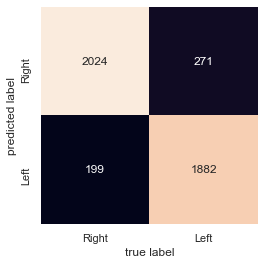

In [113]:
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()


mat = confusion_matrix(y_test_lem, rf_test_preds)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Right', 'Left'], yticklabels=['Right', 'Left'])
plt.xlabel('true label')
plt.ylabel('predicted label');

## MN Naive Bayes

In [114]:
mnb_lemma = MultinomialNB()
mnb_lemma.fit(tfidf_data_train_lem, y_train_lem)
mnb_test_preds = mnb_lemma.predict(tfidf_data_test_lem)

mnb_acc_score_lem = accuracy_score(y_test_lem, mnb_test_preds)
mnb_f1_score_lem = f1_score(y_test_lem, mnb_test_preds)
print('Multinomial Naive Bayes model accuracy')
print("Testing Accuracy: {:.4}".format(mnb_acc_score_lem))
print()
print("F1 Score: {:.4}".format(mnb_f1_score_lem))

Multinomial Naive Bayes model accuracy
Testing Accuracy: 0.8896

F1 Score: 0.8897


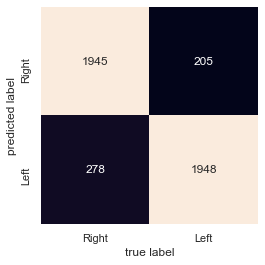

In [115]:
mat = confusion_matrix(y_test_lem, mnb_test_preds)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Right', 'Left'], yticklabels=['Right', 'Left'])
plt.xlabel('true label')
plt.ylabel('predicted label');

In [116]:
y_test_lem.index

Int64Index([51260, 62757, 50715, 42119, 18732, 84121, 51636, 22929, 28521,
            82515,
            ...
            91810, 99625, 18888, 82216, 28471, 13414, 65454, 60726, 24713,
             2859],
           dtype='int64', length=4376)

In [117]:
test = comments_df.loc[y_test_lem.index]
test['pred'] = rf_test_preds
test['pred'] = test['pred'].apply(lambda x: 'right' if x == 1 else 'left')

In [118]:
guessed_right_wrong = test[(test.comment_class != test.pred) & (test.pred == 'right')]
guessed_right_wrong.reset_index(drop=True, inplace=True)

guessed_left_wrong = test[(test.comment_class != test.pred) & (test.pred == 'left')]
guessed_left_wrong.reset_index(drop=True, inplace=True)


In [119]:
print("GUESSED RIGHT BUT WE WERE WRONG")
print("_______________________________")
for i in range(0,50):
    print(guessed_right_wrong.iloc[i].body)
    print('----------')

GUESSED RIGHT BUT WE WERE WRONG
_______________________________
Voting for Trump means voting to spend your tax dollars paying a rapist's defense attorneys.

If Republicans are spending our tax dollars on defending this disgusting pig's sexual assaults, they can just STFU about the damn debt and deficits.
----------
Not only black. Philly PD is not exactly unified after the past few years. Commissioner Outlaw seems to be getting mixed support
----------
Trump tried to hide behind a wall of regular testing, no expense spared. The tests aren't 100% and since his core team couldn't be seen to take CV19 seriously, someone was going to catch it and slip through the net. 

Nature will find a way...
----------
I don't understand "could face" Federal charges. If I were caught after having helped myself to a bag of mail with the intent to discard ballot envelopes while the carrier left his truck to take a piss, I would be serving prison time.  That's just me...a citizen. A Federal employee entr

In [120]:
print("GUESSED LEFT BUT WE WERE WRONG")
print("______________________________")
for i in range(0,50):
    print(guessed_left_wrong.iloc[i].body)
    print('----------')

GUESSED LEFT BUT WE WERE WRONG
______________________________
Truck in my neighborhood:

Gadsden Flag

COME AND TAKE IT sticker

Back the Blue/Thin Blue Line

???!!!
----------
If Hunter Biden had the last name of Trump and this were to come to light, the MSM would be running with this 24/7. The double standard here is plain as day and absolutely disgusting for people paying attention. It's time we vote and send Biden into retirement for good!
----------
Why don't more Muslims who are lucky to live in France/Europe instead of the shitty countries they came from do more to help the fight against extremism?
----------
It is a very dangerous game the Democrats are playing by blaming foreign governments for their personal failings. When the Russian actually *do* decide to meddle in our elections, no one will believe it because the liberal cried wolf too many times.

Joe Biden is a habitual liar and a generally nasty human being. He knows how to hide it a bit because he has been a chameleon